In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from rcpsp_inst import RCPSPInstance, load_dataset
from net import Net
from aco import ACO_RCPSP
import random

# torch.manual_seed(1234)

lr = 1e-3
EPS = 1e-10
ALPHA = 0.05
T=20
device = 'cpu'

In [2]:
def train_instance(model, optimizer, rcpsp: RCPSPInstance, n_ants):
    model.train()
    pyg_data = rcpsp.to_pyg_data()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    phe_mat, heu_mat = model.reshape(pyg_data, phe_vec) + EPS, model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO_RCPSP(
        rcpsp,
        n_ants=n_ants,
        pheromone=phe_mat,
        heuristic=heu_mat,
        device=device,
        train = True
    )
    
    costs, log_probs = aco.sample()
    assert log_probs is not None
    assert pyg_data.num_nodes is not None
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    k_sparse = pyg_data.num_edges // pyg_data.num_nodes
    entropy_loss = ALPHA * (-torch.sum(Categorical(phe_mat).entropy()) / k_sparse)
    # print(reinforce_loss.item(), entropy_loss.item())
    loss = reinforce_loss + entropy_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def infer_instance(model, rcpsp, n_ants):
    model.eval()
    pyg_data = rcpsp.to_pyg_data()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    phe_mat, heu_mat = model.reshape(pyg_data, phe_vec) + EPS, model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO_RCPSP(
        rcpsp,
        n_ants=n_ants,
        pheromone=phe_mat,
        heuristic=heu_mat,
        device=device,
    )
    costs, log_probs = aco.sample()
    result = aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = result.cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost

In [3]:
def train_epoch(trainset,
                n_ants, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    losses = []
    for _ in range(steps_per_epoch):
        data = trainset[random.randint(0,len(trainset)-1)]
        loss = train_instance(net, optimizer, data, n_ants)
        losses.append(loss)
    return losses

@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for instance in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, instance, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    trainset, testset = load_dataset(f"../data/rcpsp/j{n_node}rcp")
    testset = testset[:20]
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, testset, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    loss_list = []
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        losses = train_epoch(trainset, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, testset, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        loss_list.append(sum(losses))
        
    print('total training duration:', sum_time)
    for epoch in range(epochs):
        print(f'[epoch {epoch}] loss:', loss_list[epoch], "val:", val_results[epoch])

    torch.save(net.state_dict(), f'../pretrained/rcpsp/rcpsp{n_node}-{net.emb_net.feats}.pt')

total training duration: 76.75403499603271
[epoch 0] loss: 102.55696406960487 val: (85.0099998474121, 73.0, 66.35)
[epoch 1] loss: 189.7732030749321 val: (79.65500049591064, 68.45, 62.5)
[epoch 2] loss: 150.83647736907005 val: (73.23999996185303, 64.9, 59.8)
[epoch 3] loss: 147.63104391098022 val: (73.50500011444092, 65.35, 60.3)
[epoch 4] loss: 170.5229034423828 val: (73.03499965667724, 64.35, 59.5)
[epoch 5] loss: 124.21239668130875 val: (73.2700002670288, 63.6, 59.9)
[epoch 6] loss: 126.38922393321991 val: (74.21000003814697, 65.95, 59.15)
[epoch 7] loss: 152.88149498403072 val: (73.41999988555908, 64.15, 59.9)
[epoch 8] loss: 181.1689710021019 val: (72.65000019073486, 64.65, 59.95)
[epoch 9] loss: 180.40647286176682 val: (75.53500003814698, 67.2, 61.15)
[epoch 10] loss: 279.7634215205908 val: (73.7350004196167, 65.0, 59.4)
[epoch 11] loss: 143.6997108310461 val: (74.32999954223632, 65.5, 60.05)
[epoch 12] loss: 166.4620028436184 val: (73.42000026702881, 65.25, 60.25)
[epoch 13] los

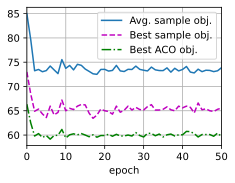

In [5]:
# j30
n_node, n_ants = 30, 10
steps_per_epoch = 32
epochs = 50
train(n_node, n_ants, steps_per_epoch, epochs)

total training duration: 50.567198038101196
[epoch 0] loss: 674.8909748792648 val: (136.7799991607666, 123.3, 106.8)
[epoch 1] loss: 288.00464767217636 val: (129.05000114440918, 115.6, 101.65)
[epoch 2] loss: 433.6425178050995 val: (114.9199993133545, 103.45, 93.95)
[epoch 3] loss: 782.5039141178131 val: (117.5400001525879, 107.25, 94.3)
[epoch 4] loss: 448.8040200769901 val: (114.89000015258789, 104.1, 94.5)
[epoch 5] loss: 825.7128981351852 val: (115.39000053405762, 105.25, 94.75)
[epoch 6] loss: 989.0171246528625 val: (117.5700008392334, 105.2, 94.6)
[epoch 7] loss: 391.5092440843582 val: (116.5200008392334, 106.3, 94.65)
[epoch 8] loss: 553.7193531990051 val: (116.55999946594238, 105.5, 95.1)
[epoch 9] loss: 675.0657387971878 val: (117.16000022888184, 106.6, 94.35)
[epoch 10] loss: 631.4607099294662 val: (117.33999938964844, 106.15, 93.95)
[epoch 11] loss: 710.3232796192169 val: (116.05999984741212, 104.95, 94.4)
[epoch 12] loss: 455.1275509297848 val: (115.72000007629394, 105.6, 9

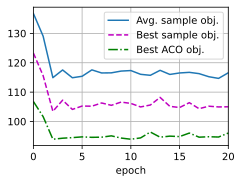

In [7]:
# j60
n_node, n_ants = 60, 5
steps_per_epoch = 32
epochs = 20
train(n_node, n_ants, steps_per_epoch, epochs)

total training duration: 119.73932266235352
[epoch 0] loss: 3069.241044998169 val: (268.5500015258789, 249.3, 231.75)
[epoch 1] loss: 2202.5308005809784 val: (265.289998626709, 247.5, 229.5)
[epoch 2] loss: 1658.8166870474815 val: (242.46999816894532, 227.4, 212.9)
[epoch 3] loss: 1515.946814596653 val: (246.03999862670898, 232.7, 214.6)
[epoch 4] loss: 1650.086360692978 val: (258.860001373291, 244.45, 227.65)
[epoch 5] loss: 2091.698366045952 val: (244.83000106811522, 231.1, 215.0)
[epoch 6] loss: 1649.9564871788025 val: (242.5000015258789, 230.2, 214.25)
[epoch 7] loss: 1835.7953181266785 val: (243.05999984741212, 228.35, 211.45)
[epoch 8] loss: 2278.5155904591084 val: (242.22999572753906, 226.85, 212.35)
[epoch 9] loss: 2416.570577144623 val: (245.22999954223633, 231.85, 216.6)
[epoch 10] loss: 1358.6816601753235 val: (243.4800003051758, 229.4, 213.55)
[epoch 11] loss: 2306.8822848796844 val: (240.19999923706055, 226.8, 212.85)
[epoch 12] loss: 1929.0680603981018 val: (241.989998626

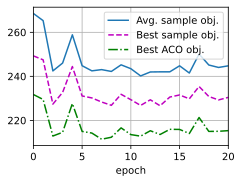

In [8]:
# j120
n_node, n_ants = 120, 5
steps_per_epoch = 32
epochs = 20
train(n_node, n_ants, steps_per_epoch, epochs)